In [1]:
import sys  
import os
from pathlib import Path
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

# Set Root Directory
root = Path('/Users/flipflops/engineer/soccerEye')
sys.path.insert(0, str(root))

import utils

from IPython.display import Video
import cv2

import methods 

In [2]:
# Set Dataset Path
dataset = Path('../dataset/dfl-bl/')
dataset = dataset.resolve()
print(f'Dataset Location : {dataset}')
dataset_files = utils.util_searching_all_files(dataset)[0]
print(f'Number of files in dataset : {len(dataset_files)}')

Dataset Location : /Users/flipflops/engineer/soccerEye/dataset/dfl-bl
Number of files in dataset : 50


Video Picked (index) : 40
Total Frames in Video: 750.0


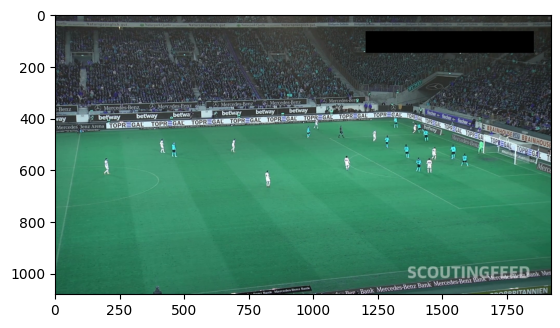

In [3]:
# Picking a Random Video

videoPick = np.random.randint(len(dataset_files))
print(f'Video Picked (index) : {videoPick}')

cap = cv2.VideoCapture(str(dataset_files[videoPick]))

# Picking a Random Frame From Video 

total_frames = cap.get(7)
print(f'Total Frames in Video: {total_frames}')

framePick = np.random.randint(total_frames)

# Display Random Frame 
if framePick < int(total_frames):
    cap.set(1, framePick)
    ret, frame = cap.read()
    imshow(frame)
else:
    print('Frame Number selected larger than max frame')

## Method 1 

In [ ]:


# Load iamge, grayscale, adaptive threshold
image = frame.copy()
result = image.copy()
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,51,9)

# Fill rectangular contours
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(thresh, [c], -1, (255,255,255), -1)

# Morph open
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=4)

# Draw rectangles
cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 3)

imshow(thresh)



In [ ]:
imshow(opening)


In [ ]:
imshow(image)

----------------


## Method 2 
[src](https://stackoverflow.com/questions/68725183/finding-all-polygons-in-an-image-opencv-and-python)

Tbh its a pretty good focussing algorithm

In [ ]:
import cv2
import numpy as np
from scipy import misc
from scipy.ndimage import gaussian_filter
from scipy.signal import medfilt2d
import random


In [ ]:
# Smooth
image = frame.copy()
image = cv2.bilateralFilter(image, 15, 80, 80,None)
imshow(image)

In [ ]:
# Gray
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
imshow(gray)

In [ ]:
# Edges Dialater
thr1=50
thr2=200
kernel = np.ones((5,5 ),np.float32)/49
gray = cv2.dilate(gray, kernel, iterations=3)
imshow(gray)


In [ ]:
# Eroded Edges
gray = cv2.erode(gray, kernel, iterations=1)
imshow(gray)

In [ ]:
# Thresholded Canny 
edged = cv2.Canny(gray, thr1, thr2)
imshow(edged)

In [ ]:
kernel = np.ones((3,3), np.uint8)
contours, hierarchy = cv2.findContours(edged, 
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print("Number of Contours found = " + str(len(contours)))
cntFound = 0
finalCnt = []
for cnt in contours :
    area = cv2.contourArea(cnt)
    # print("area",area)
    # Shortlisting the regions based on there area.
    if area > 100: 
        # approx = cv2.approxPolyDP(cnt, 
        #                           0.009 * cv2.arcLength(cnt, True), True)
        approx = cv2.approxPolyDP(cnt,0.001 * cv2.arcLength(cnt, True), True)
        M = cv2.moments(cnt)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
   
        # Checking if the no. of sides of the selected region is 7.
        # if(len(approx) == 7): 
        r=random.randint(0,255)
        g=random.randint(0,255)
        b=random.randint(0,255)
        cv2.drawContours(image, [approx], -1, (r, g, b), 3)
        cv2.putText(image, str(cntFound), (cX - 20, cY - 20),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (r, g, b), 2)
        
        cntFound = 1 + cntFound
        finalCnt.append(cnt)

print("Total found after area threshold = ", cntFound)  

imshow(image)


In [ ]:
imshow(edged)

In [ ]:
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20,
              param1=130,
              param2=100,
              minRadius=20,
              maxRadius=0)

In [ ]:
len(circles[0])

In [ ]:
circle_im = frame.copy()
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    cv2.circle(circle_im,(i[0],i[1]),i[2],(0,255,0),2)
    cv2.circle(circle_im,(i[0],i[1]),2,(0,0,255),3)

In [ ]:
imshow(circle_im)

## Method 3 : Ellipse 

In [ ]:
import matplotlib.pyplot as plt

from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

In [ ]:
image_rgb = frame.copy()
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = color.rgb2gray(image_rgb)

In [ ]:
(frame)

In [ ]:
edges = canny(image_gray, sigma=2.0,
              low_threshold=0.55, high_threshold=0.8)

# Perform a Hough Transform
# The accuracy corresponds to the bin size of a major axis.
# The value is chosen in order to get a single high accumulator.
# The threshold eliminates low accumulators
result = hough_ellipse(edges, accuracy=20, threshold=250,
                       min_size=100, max_size=120)
result.sort(order='accumulator')

# Estimated parameters for the ellipse
best = list(result[-1])
yc, xc, a, b = [int(round(x)) for x in best[1:5]]
orientation = best[5]

# Draw the ellipse on the original image
cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
image_rgb[cy, cx] = (0, 0, 255)
# Draw the edge (white) and the resulting ellipse (red)
edges = color.gray2rgb(img_as_ubyte(edges))
edges[cy, cx] = (250, 0, 0)

fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4),
                                sharex=True, sharey=True)

ax1.set_title('Original picture')
ax1.imshow(image_rgb)

ax2.set_title('Edge (white) and result (red)')
ax2.imshow(edges)

plt.show()

In [ ]:
result

## Method 4 : Vanishing Point

[src](https://stackoverflow.com/questions/57535865/extract-vanishing-point-from-lines-with-open-cv) : Good instruction of parametric vs otherwise

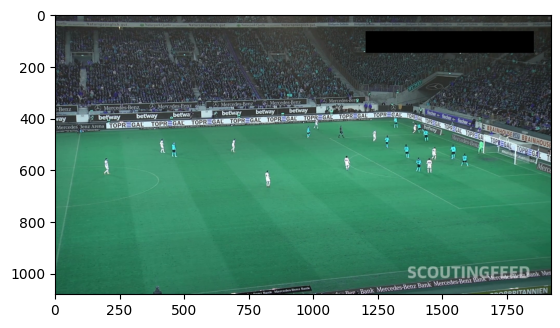

In [64]:
image = frame.copy()
imshow(image)

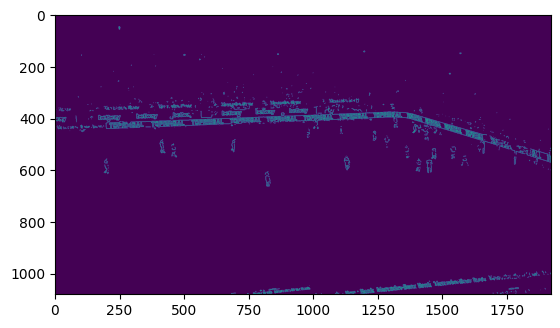

In [65]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
edges_basic = cv2.Canny(gray, 500, 460)
imshow(edges_basic)

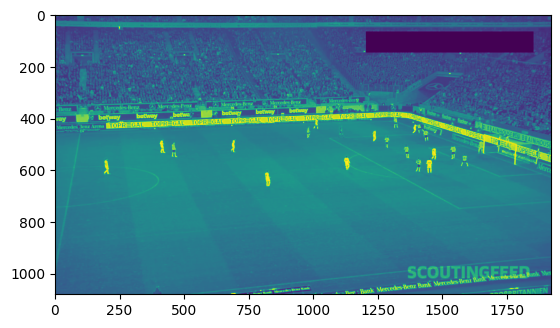

In [66]:
thr1=10
thr2=100
kernel = np.ones((3,3),np.float32)/49

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gray = cv2.dilate(gray, kernel, iterations=1)
imshow(gray)


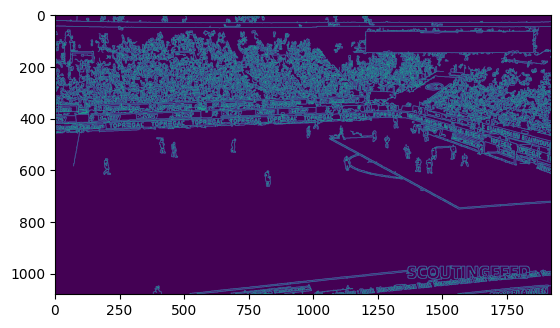

In [67]:
edges_dialated = cv2.Canny(gray, 0, 200)
imshow(edges_dialated)

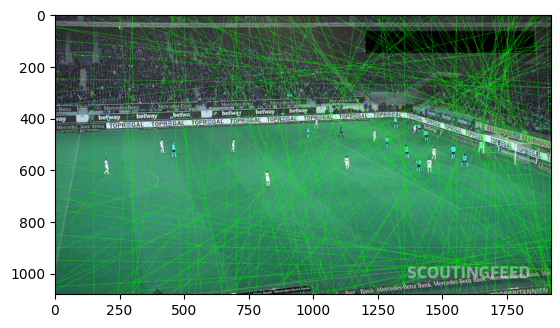

In [71]:

lines = cv2.HoughLines(edges_dialated, 200, np.pi/180, 200)
line_im = image.copy()
for line in lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 10000*(-b))
    y1 = int(y0 + 10000*(a))
    x2 = int(x0 - 10000*(-b))
    y2 = int(y0 - 10000*(a))
    cv2.line(line_im,(x1,y1),(x2,y2),(0,255,0),1)

imshow(line_im)